In this notebook we test FFNN for Honeycomb Heisenberg model

Honeycomb 3x3 has 18 spins and is numerically solvable. We test for 3x3 and then try to approximate for 5x5 honeycomb, which has 50 spins

In [1]:
import netket as nk
import json
import matplotlib.pyplot as plt
from time import time
from pathlib import Path
from Models import FeedForwardNeuralNetwork

In [2]:
res_path = Path('./Simulations/5-FFNNComparison')
image_path = Path('./images/5-FFNNComparison')
extent = [3, 3]
alpha_list = [(0.3,), (1,), (2,), (1, 1), (1, 2, 1)]
Sz = 0
lr = 0.05
ds = 0.1
n_iter = 1000
n_samples = 800
ffnn_results = []
times = []

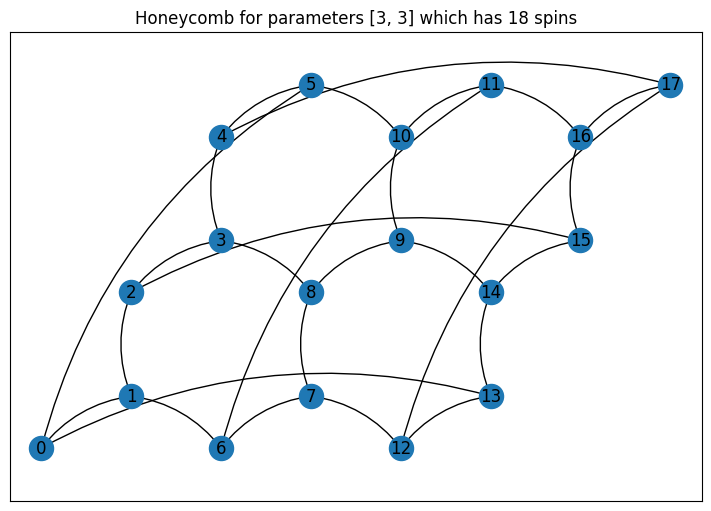

In [3]:
figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(7, 5))
honey = nk.graph.Honeycomb(extent=extent, pbc=True)
honey.draw(ax=axes)
axes.set(xticks=[], yticks=[], 
         title=f'Honeycomb for parameters {extent} which has {honey.n_nodes} spins');

In [4]:
hilbert = nk.hilbert.Spin(s=1/2, total_sz=Sz, N=honey.n_nodes)
hamiltonian = nk.operator.Heisenberg(hilbert=hilbert, graph=honey, J=1)
eval_gs = nk.exact.lanczos_ed(hamiltonian, k=1, compute_eigenvectors=False)[0]
eval_gs

-40.38866334601949

Comparing different Feed Forward Neural Networks

In [5]:
for alpha in alpha_list:
    honey = nk.graph.Honeycomb(extent=extent, pbc=True)
    hilbert = nk.hilbert.Spin(s=1/2, total_sz=Sz, N=honey.n_nodes)
    hamiltonian = nk.operator.Heisenberg(hilbert=hilbert, graph=honey, J=1)
    sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=honey)
    optimizer = nk.optimizer.Sgd(learning_rate=lr)
    sr = nk.optimizer.SR(diag_shift=ds)
    ffnn = FeedForwardNeuralNetwork(layer_alpha=alpha)
    vstate = nk.vqs.MCState(sampler, ffnn, n_samples=n_samples)
    gs = nk.VMC(hamiltonian=hamiltonian, optimizer=optimizer, 
                preconditioner=sr, variational_state=vstate)
    
    start = time()
    gs.run(n_iter=n_iter, out=(chain_path := f'{res_path}/HeisenbergHoneycomb/ffnnN{honey.n_nodes}'
                              f'alpha{list(alpha)}{"Sz0" if Sz == 0 else ""}lr{lr}niter{n_iter}'))
    print(f'Time: {(t := time()-start):.3f} seconds')
    ffnn_results.append(json.load(open(f'{chain_path}.log')))
    times.append(t)

  0%|          | 0/1000 [00:00<?, ?it/s]

Time: 24.186 seconds


  0%|          | 0/1000 [00:00<?, ?it/s]

Time: 39.695 seconds


  0%|          | 0/1000 [00:00<?, ?it/s]

Time: 63.455 seconds


  0%|          | 0/1000 [00:00<?, ?it/s]

Time: 69.969 seconds


  0%|          | 0/1000 [00:00<?, ?it/s]

Time: 101.873 seconds


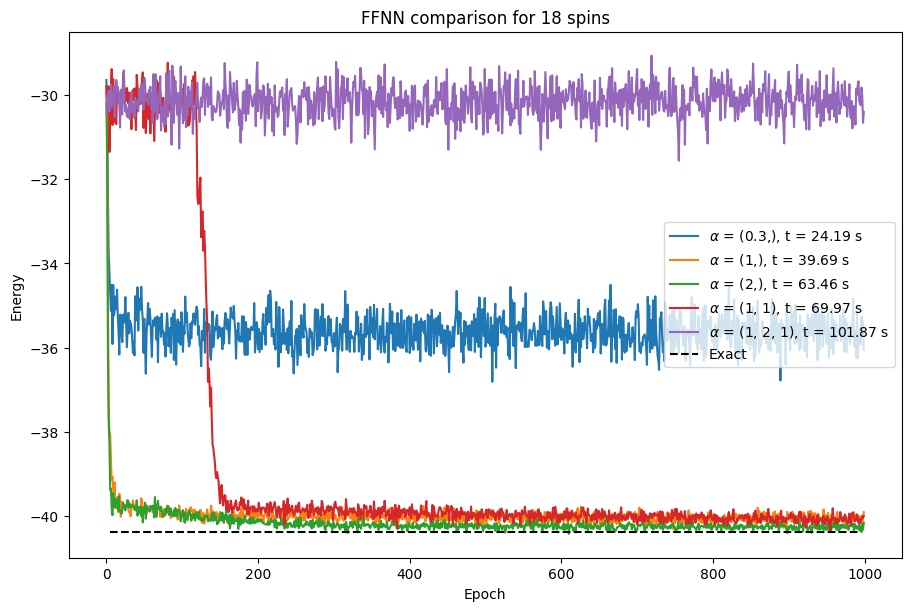

In [6]:
figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(9, 6))
for ffnn_res, alpha, t in zip(ffnn_results, alpha_list, times):
    axes.plot(ffnn_res['Energy']['iters'], ffnn_res['Energy']['Mean'], 
              label=f'$\\alpha$ = {alpha}, t = {t:.2f} s')
axes.axhline(y=eval_gs, xmin=0.05, xmax=0.95, color='black', linestyle='--', label='Exact')
axes.set(xlabel='Epoch', ylabel='Energy', 
         title=f'FFNN comparison for {honey.n_nodes} spins')
axes.legend()
figure.savefig(image_path / f'Honeycomb{extent}Iter{n_iter}Samples{n_samples}.png');

Testing again for 50 spins and 1000 epochs

In [7]:
extent = [5, 5]
lr = 0.05
ds = 0.1
n_iter = 2000
n_samples = 800
ffnn_results = []
times = []

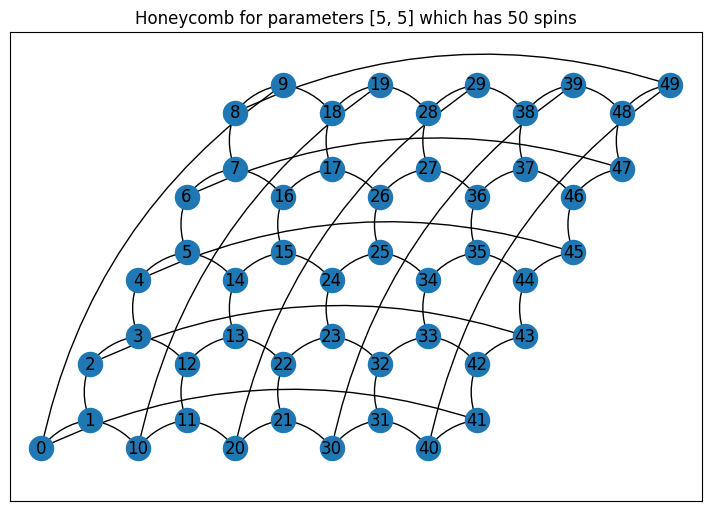

In [8]:
figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(7, 5))
honey = nk.graph.Honeycomb(extent=extent, pbc=True)
honey.draw(ax=axes)
axes.set(xticks=[], yticks=[], 
         title=f'Honeycomb for parameters {extent} which has {honey.n_nodes} spins');

In [9]:
for alpha in alpha_list:
    honey = nk.graph.Honeycomb(extent=extent, pbc=True)
    hilbert = nk.hilbert.Spin(s=1/2, total_sz=Sz, N=honey.n_nodes)
    hamiltonian = nk.operator.Heisenberg(hilbert=hilbert, graph=honey, J=1)
    sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=honey)
    optimizer = nk.optimizer.Sgd(learning_rate=lr)
    sr = nk.optimizer.SR(diag_shift=ds)
    ffnn = FeedForwardNeuralNetwork(layer_alpha=alpha)
    vstate = nk.vqs.MCState(sampler, ffnn, n_samples=n_samples)
    gs = nk.VMC(hamiltonian=hamiltonian, optimizer=optimizer, 
                preconditioner=sr, variational_state=vstate)
    
    start = time()
    gs.run(n_iter=n_iter, out=(chain_path := f'{res_path}/HeisenbergHoneycomb/ffnnN{honey.n_nodes}'
                              f'alpha{list(alpha)}{"Sz0" if Sz == 0 else ""}lr{lr}niter{n_iter}'))
    print(f'Time: {(t := time()-start):.3f} seconds')
    ffnn_results.append(json.load(open(f'{chain_path}.log')))
    times.append(t)

  0%|          | 0/2000 [00:00<?, ?it/s]

Time: 189.584 seconds


  0%|          | 0/2000 [00:00<?, ?it/s]

Time: 444.613 seconds


  0%|          | 0/2000 [00:00<?, ?it/s]

Time: 762.717 seconds


  0%|          | 0/2000 [00:00<?, ?it/s]

Time: 790.143 seconds


  0%|          | 0/2000 [00:00<?, ?it/s]

Time: 1633.760 seconds


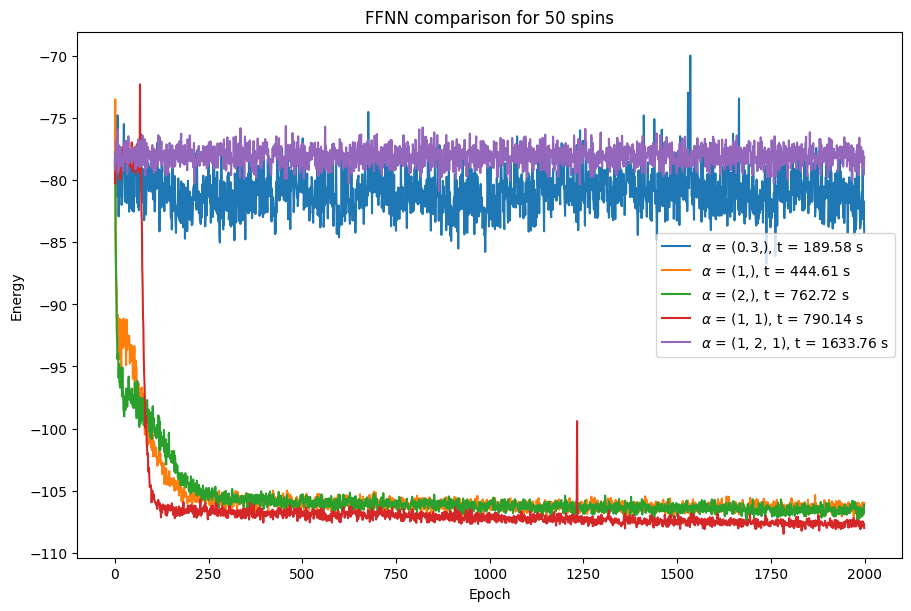

In [10]:
figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(9, 6))
for ffnn_res, alpha, t in zip(ffnn_results, alpha_list, times):
    axes.plot(ffnn_res['Energy']['iters'], ffnn_res['Energy']['Mean'], 
              label=f'$\\alpha$ = {alpha}, t = {t:.2f} s')
axes.set(xlabel='Epoch', ylabel='Energy', 
         title=f'FFNN comparison for {honey.n_nodes} spins')
axes.legend()
figure.savefig(image_path / f'Honeycomb{extent}Iter{n_iter}Samples{n_samples}.png');

As we can see, the best performance isn't straightforward. For smaller number of spins the best performing model was $\alpha = 2$, but for 50 spins better option was two-layer model $\alpha = (1, 1)$